# Tutorial 1: EasyVVUQ

The Role of Uncertainty in Mathematical Modelling of Pandemics - Session 2: Wider Applications of VVUQ Methods - 9th February 2022


* Forward uncertainty propagation: computing the output distribution of a computational model, given *assumed* probability density functions for the input parameters of the model (see image below). 

* [EasyVVUQ](https://github.com/UCL-CCS/EasyVVUQ) is VECMA's forward uncertainty propagation toolkit.

![](images/forward.png)

Author: Wouter Edeling, CWI Scientific Computing Group (Wouter.Edeling@CWI.nl)

## Installation

* EasyVVUQ: via git clone or by eceuting the command below

You will also need seaborn installed for some of the plots. Uncomment the install line below if need be.

In [1]:
!pip install easyvvuq
#!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


## Sparse-grid forward UQ in theory

### Making a interpolation-based surrogate with 1 uncertain input parameter


Let $f^{(1)}(x)$ be a one-dimensional function. We aim to create an interpolation of $f^{(1)}$, denoted by

\begin{align}
 I^{(l)}f^{(1)}(x) = \sum_{i=1}^{m_l} f(x_{i}^{(l)})a^{(l)}_i(x).
 \label{eq:sc1d}
\end{align}

Here, $l$ is the so-called *level* of the interpolant. It is an index which links to a **one-dimensional** set of collocation points $\{x^{l}_i\}$, for $i=1,\cdots, m_l$. We can select these points from different families, typically they'll be the abscissas of some quadrature rule. For instance, a Clenshaw-Curtis (CC) rule can generate different collocation points in $[0,1]$ such that

* Level 1: $x^{(1)}_i \in \{0.5\}$,
* Level 2: $x^{(2)}_i \in \{0.0, 0.5, 1.0\}$,
* Level 3: $x^{(3)}_i \in \{0.0, 0.146, 0.5, 0.854, 1.0\}$.

Note that here, the higher level collocation point sets include all points from previous levels. When this is the case, we say that the quadrature rule is **nested**. This leads to efficient sampling plans in higher dimensions, but nestedness is not a strict requirement for sparse grid interpolation or integration. This does (often) lead to 1D quadrature rules which increase exponentially, such that the number of points is given by

\begin{align}
 m_l = 
 \begin{cases}
  2^{l-1} + 1 & l > 1 \\
  1 & l = 1
 \end{cases}  
\end{align}

Finally, the $a^{(l)}_i(x)$ are the basis functions used for interpolation. In the case of the **Stochastic Collocation** (SC) method, these are often (although not necessarily) the Lagrange interpolation polynomials, given by

\begin{align}
a^{(l)}_i(x) = \prod_{\substack{1\leq j \leq m_l \\ j \neq i}} \frac{x - x_j}{x_i - x_j}
\end{align}

A property of the Lagrange polynomial associated with the i-th collocation point is that $a^{(l)}_i(x_i) = 1$ at this point, and $a^{(l)}_i(x_j) = 0$ at all other collocation points $x_j$. The interpolation $I^{(l)}f^{(1)}$ will therefore exactly reproduce the code outputs $f^{(1)}(x_i)$ at the collocation points $x_i$.

### Refinement

Let us define the following difference formulas for interpolation in 1D:

\begin{align}
 \Delta^{(l)} f^{(1)} := I^{(l)}f^{(1)} - I^{(l-1)}f^{(1)}\quad\mathrm{where}\quad
 I^{(0)}f^{(1)}:=0.
 \label{eq:Delta1d}
\end{align}

That is, $ \Delta^{(l)} f^{(1)}$ is just the difference between the interpolations at successive levels. These difference formulas are often used in both sparse-grid interpolation (and quadrature), see the figure below.

![](images/fig1.png)


When interpolating a level $l-1$ interpolant using a level $l$ interpolating we retrieve the former, i.e.

\begin{align}
 I^{(l)}\left(I^{(l-1)}f^{(l)}\right) = I^{(l-1)}f^{(l)}.
\end{align}


Thus, a lower level interpolant can be exactly interpolated by a higher level interpolant (which is true for both nested and non-nested collocation points), see Figure below:

![](images/fig2.png)
*The blue solid line is the exact 1D function $f^{(1)}$. The red striped line is a (non-nested) level $l$ interpolant. The green striped line is a lower-level $l-1$ counterpart, constructed from function evaluations at  the green star symbols.. If we evaluate the level $l-1$ interpolant at the level $l$ collocation, we obtain the blue squares. Clearly, if these function values are used to construct a level $l$ interpolant of $I^{(l-1)}f^{(1)}$, which would be $I^{(l)}\left(I^{(l-1)}f^{(1)}\right)$, we just retrieve $I^{(l-1)}f^{(1)}$.*

We can therefore write the difference formula as

\begin{align}
 \Delta^{(l)}f^{(1)} = I^{(l)}f^{(1)} - I^{(l-1)}f^{(1)} =  I^{(l)}f^{(1)} - I^{(l)}\left(I^{(l-1)}f^{(1)}\right) = \sum_{i = 1}^{m_l}f(x^{(l)}_i)a^{(l)}_i - \sum_{i=1}^{m_l}I^{(l-1)}f^{(1)}(x^{(l)}_i)a^{(l)}_i = \nonumber\\
 \sum_{i=1}^{m_l}\left[f(x^{(l)}_i) - I^{(l-1)}f^{(1)}(x^{(l)}_i)\right]a^{(l)}_i = \sum_{i=1}^{m_l}w^{(l)}_ia^{(l)}_i.
 \label{eq:diff0}
\end{align}

Here, $w^{(l)}_i:=f(x^{(l)}_i) - I^{(l-1)}f^{(1)}(x^{(l)}_i)$ is the **hierarchical surplus**, defined as the difference between the code output at a collocation point $x^{(l)}_i$ at level $l$, minus the level $l-1$ polynomial approximation of the code output at the same location. This can be thought of as a local measure of the accuracy of the interpolation. Furthermore, we can also write the interpolation $I^{(l)}f^{(1)}(x)$ in terms of the difference formulas, in which case the $a^{l}_i$ basis function will form a hierarchical basis as

\begin{align}
 I^{(L)}f^{(1)} = \sum_{l=1}^L \Delta^{(l)}f^{(1)} = \sum_{l=1}^L\sum_{i=1}^{m_l}w^{(l)}_i a^{(l)}_i
 \label{eq:diff1}
\end{align}

Hence, to obtain a level $L$ interpolant, we can just create a telescopic sum of the difference formulas, which is the first equality above. The second equality is obtained by simply plugging in the formula for $\Delta^{(l)}f^{(1)}$, and it shows that the $a^{(l)}_i$ form a hierarchical basis due to summation over $l$, which increases the number collocation point $m_l$ at every new level. This is also sketched in the Figure below, which assumes linear basis functions for simplicity.

![](images/fig3.png)
*Top left is a standard linear (finite-element) basis, with below it a corresponding linear interpolant. Top right displays a linear hierarchical basis. Below it we show a series of 3 hierarchical interpolants ($L=1,2$ and $3$) and the hierarchical surplus coefficients $w^{(l)}_i$ used in their construction. Figure recreated from [3]*

**Why should we care?**

The formula above is the same as $I^{(l)}f^{(1)}$ in the beginning, as both are 1D interpolation formulas, only written differently, so why should we complicate things with a hierarchical notation? 

One advantage of adopting the hierarchical notation is that it naturally allows for **refinement**, i.e. adding more points to an existing sampling plan, by adding another level. If we select a nested quadrature rule, adding another level means we only have to evaluate the (expensive) code at a relatively small number of *new* points, the other points are quaranteed to be present in one or more of the previous levels, see the CC example at the beginning of this section.

In the case more than one uncertain input, sampling plans are create using **tensor products of 1D collocation points**. Here, **a hierarchical construction leads to a sparse sampling plan**, with much less code evaluations compared to "standard" sampling plans.

![](images/drawing.png)

## Sparse grid UQ on an HIV model

Here we will look at a HIV model [1], taken from the [Active Subspace data set repository](https://github.com/paulcon/as-data-sets). It models the T-cell count during different stages of the disease, and has 27 input parameters spread out over 7 coupled ODEs.

### HIV model

From [here](https://github.com/paulcon/as-data-sets/blob/master/HIV/HIV.ipynb) we find the following description of the model, see also [4]. The 7 coupled ordinary differential equations are given by:

$$
\begin{align}
\frac{dT}{dt} &= s_1 + \frac{p_1}{C_1+V}TV - \delta_1T - (K_1V + K_2M_I)T,\\
\frac{dT_I}{dt} &= \psi(K_1V + K_2M_I)T + \alpha_1T_L-\delta_2T_I-K_3T_ICTL,\\
\frac{dT_L}{dt} &= (1-\psi)(K_1V+K_2M_I)T-\alpha_1T_L-\delta_3T_L,\\
\frac{dM}{dt} &= s_2+K_4MV-K_5MV-\delta_4M,\\
\frac{dM_I}{dt} &= K_5MV-\delta_5M_I-K_6M_ICTL,\\
\frac{dCTL}{dt} &= s_3 + (K_7T_I+K_8M_I)CTL-\delta_6CTL,\\
\frac{dV}{dt} &= K_9T_I+K_{10}M_I-K_{11}TV-(K_{12}+K_{13})MV-\delta_7V,
\end{align}
$$

where $T(t)$ is the CD4$^+$ T-cell population, $T_I$ is the actively infected T-cell population, $T_L$ represents latently-infected T-cells, $M$ is macrophages, $M_I$ is infected macrophages, $CTL$ is cytotoxic lymphocytes, and $V$ is virions. The model's 27 parameters are summarized in the table below.

Parameter|Nominal Value|Distribution (U(min, max))
:-------:|:-----------:|:-------------:
$s_1$|  10 |  U(9.75, 10.25)
$s_2$|   .15 |  U(.14625, .15375)
$s_3$|   5  | U(4.875, 5.125)
$p_1$|   .2 |  U(.195, .205)
$C_1$|   55.6  | U(54.21, 56.99)
$K_1$|   3.87e-3 |  U(3.77325e-3, 3.96675e-3)
$K_2$|   1e-6  | U(.975e-6, 1.025e-6)
$K_3$|   4.5e-4 |  U(4.3875e-4, 4.6125e-4)
$K_4$|   7.45e-4 |  U(7.26375e-4, 7.63625e-4)
$K_5$|   5.22e-4 |  U(5.0895e-4, 5.3505e-4)
$K_6$|   3e-6  | U(2.925e-6, 3.075e-6)
$K_7$|   3.3e-4  | U(3.2175e-4, 3.3825e-4)
$K_8$|   6e-9  | U(5.85e-9, 6.15e-9)
$K_9$|   .537 |  U(.523575, .550425)
$K_{10}$|   .285 |  U(.277875, .292125)
$K_{11}$|   7.79e-6 |  U(7.59525e-6, 7.98475e-6)
$K_{12}$|   1e-6  | U(.975e-6, 1.025e-6)
$K_{13}$|   4e-5   |U(3.9e-5, 4.1e-5)
$\delta_1$|   .01 |  U(.00975, .01025)
$\delta_2$|   .28  | U(.273, .287)
$\delta_3$|   .05  | U(.04875, .05125)
$\delta_4$|   .005  | U(.004875, .005125)
$\delta_5$|   .005 |  U(.004875, .005125)
$\delta_6$|   .015 |  U(.014625, .015375)
$\delta_7$|   2.39 |  U(2.33025, 2.44975)
$\alpha_1$|   3e-4 |  U(2.925e-4, 3.075e-4)
$\psi$|   .97 |  U(.94575, .99425)

The limits on the uniform distributions are 2.5% above and below the nominal values. 


In [2]:
import os
import numpy as np
import easyvvuq as uq
import chaospy as cp
import matplotlib.pyplot as plt
import seaborn as sns
from easyvvuq.actions import CreateRunDirectory, Encode, Decode, ExecuteLocal, Actions

### Setting up an EasyVVUQ campaign

We first set up the `params` dictionary, in which we specify the name, type and default value of each input:

In [3]:
# default values
nominal = np.array([10, .15, 5, .2, 55.6, 3.87e-3, 1e-6, 4.5e-4, 7.45e-4, 5.22e-4, 3e-6,\
    3.3e-4, 6e-9, .537, .285, 7.79e-6, 1e-6, 4e-5, .01, .28, .05, .005, .005, .015, 2.39,\
    3e-4, .97])

# parameter names
param_names = ['s_1', 's_2', 's_3', 'p_1', 'C_1', 'K_1', 'K_2', 'K_3', 'K_4', 'K_5', 'K_6',
               'K_7', 'K_8', 'K_9', 'K_10', 'K_11', 'K_12', 'K_13', 'delta_1', 'delta_2', 'delta_3',
               'delta_4', 'delta_5', 'delta_6', 'delta_7', 'alpha_1', 'psi']
# params dict
params = {}
for idx, name in enumerate(param_names):
    params[name] = {'type': 'float', 'default': nominal[idx]}

params

{'s_1': {'type': 'float', 'default': 10.0},
 's_2': {'type': 'float', 'default': 0.15},
 's_3': {'type': 'float', 'default': 5.0},
 'p_1': {'type': 'float', 'default': 0.2},
 'C_1': {'type': 'float', 'default': 55.6},
 'K_1': {'type': 'float', 'default': 0.00387},
 'K_2': {'type': 'float', 'default': 1e-06},
 'K_3': {'type': 'float', 'default': 0.00045},
 'K_4': {'type': 'float', 'default': 0.000745},
 'K_5': {'type': 'float', 'default': 0.000522},
 'K_6': {'type': 'float', 'default': 3e-06},
 'K_7': {'type': 'float', 'default': 0.00033},
 'K_8': {'type': 'float', 'default': 6e-09},
 'K_9': {'type': 'float', 'default': 0.537},
 'K_10': {'type': 'float', 'default': 0.285},
 'K_11': {'type': 'float', 'default': 7.79e-06},
 'K_12': {'type': 'float', 'default': 1e-06},
 'K_13': {'type': 'float', 'default': 4e-05},
 'delta_1': {'type': 'float', 'default': 0.01},
 'delta_2': {'type': 'float', 'default': 0.28},
 'delta_3': {'type': 'float', 'default': 0.05},
 'delta_4': {'type': 'float', 'def

Next we'll set up the **encoder**, which will create the input files for the HIV model using an input template. In this case the input file is just a comma-separated file of values. To create an EasyVVUQ input template each value is replaced by `$param_name`:

`$s_1,$s_2,$s_3,$p_1,$C_1,$K_1,$K_2,$K_3,$K_4,$K_5,$K_6,$K_7,$K_8,$K_9,$K_10,$K_11,$K_12,$K_13,$delta_1,$delta_2,$delta_3,$delta_4,$delta_5,$delta_6,$delta_7,$alpha_1,$psi`

The encoder will swap out the `$param_name` flags for values drawn from the specified input distribution.

In [4]:
# input file encoder
encoder = uq.encoders.GenericEncoder(template_fname='HIV.template', delimiter='$', target_filename='input.csv')

The HIV model writes a CSV file containing the predicted T-cell count. The **decoder** will read this file and store its contents within the EasyVVUQ database. 

In [5]:
# Quantity of Interest, also the column name of the output CSV file
QOI = 'T_cell_count'
# CSV output file decoder
decoder = uq.decoders.SimpleCSV(target_filename='output.csv', output_columns=[QOI])

We'll run the HIV ensemble locally. However, in many cases of practical interest the model will be too expensive for local execution. In this case the VECMA tools [QCG-PilotJob](https://github.com/vecma-project/QCG-PilotJob) or [FabSim3](https://github.com/djgroen/FabSim3) can be used in combination with EasyVVUQ to submit the ensemble to HPC resources.

In [6]:
# local execution of HIV_model.py
execute = ExecuteLocal('{}/HIV_model.py'.format(os.getcwd()))

Now we are combine all actions we want to execute into an `Actions` object.

In [7]:
# location where the run directories are stored
WORK_DIR = '/tmp'
# actions to be undertaken: make rundirs, encode input files, execute local model ensemble, decode output files
actions = Actions(CreateRunDirectory(root=WORK_DIR, flatten=True), Encode(encoder), execute, 
                  Decode(decoder))

The central object in the UQ analysis is a so-called Campaign. This is created as:

In [8]:
campaign = uq.Campaign(name='HIV_SC', params=params, actions=actions)

### Input specification

Next we specify a probability density function for each input parameter in the `vary` dict. Each input in the vary dict will be considered as random, and therefore part of the UQ campaign. We could select only a subset of the parameters defined in the `params` dict above. The remaining inputs will then be fixed to their default values ( also defined in the `params` dict). Here we'll just include 2 inputs to visualize the full sampling plan, and specify a uniform input distribution with bounds at $\pm 2.5 \%$ from their default value:

In [9]:
vary = {}
#Lower and upper parameter limits
xl = .975*nominal; xu = 1.025*nominal
included_params = ['K_4', 'delta_7']
for name in included_params:
    # input distributions are specified using Chaospy
    idx = param_names.index(name)
    vary[name] = cp.Uniform(xl[idx], xu[idx])
vary

{'K_4': Uniform(lower=0.000726375, upper=0.000763625),
 'delta_7': Uniform(lower=2.33025, upper=2.44975)}

### Sampler
To generate the sampling plan we select the (sparse) Stochastic Collocation sampler. The `polynomial_order` of the sampler object should be interpreted as the level (defined above) in the case of `sparse=True`. Furthermore;

* `quadrature_rule='C'`: select the Clenshaw Curtis (CC) quadrature rule
* `growth=True`: selects an exponential growth rule, making CC *nested*. This is *not* possible for every quadrature rule, see [Chaospy documentation](https://chaospy.readthedocs.io/en/master/reference/quadrature/index.html).



In [10]:
sampler = uq.sampling.SCSampler(vary=vary, polynomial_order=1, sparse = True, quadrature_rule='C', 
                                growth=True, dimension_adaptive=False)
campaign.set_sampler(sampler)

Setting `polynomial_order=1` will create a level 1 sparse grid, with just a single point:

In [11]:
def plot_sampling_plan():
    """
    Plot the sampling plan of the (first) two input dimensions
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, xlabel='x_1', ylabel='x_2')
    # the xi_d array contains the N x d sampling points, with N being the number of points and d the number of inputs
    ax.plot(sampler.xi_d[:,0], sampler.xi_d[:, 1], 'ro')
    # print the number of points to screen
    print("Number of sampling points = %d" % sampler.n_samples)

Number of sampling points = 1


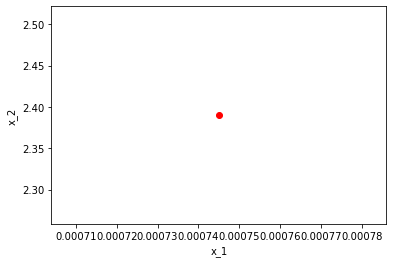

In [12]:
plot_sampling_plan()

We can refine the grid to the next level via `next_level_sparse_grid`, only evaluating the code at the *new* sampling points. We do this a number of times, plotting the 2D sampling plan each time. 

Number of sampling points = 5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.36it/s]


Number of sampling points = 13


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.34it/s]


Number of sampling points = 29


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.28it/s]


Number of sampling points = 65


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:04<00:00,  8.78it/s]


Number of sampling points = 145


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:09<00:00,  8.18it/s]


Number of sampling points = 321


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 176/176 [00:21<00:00,  8.01it/s]


<Figure size 432x288 with 0 Axes>

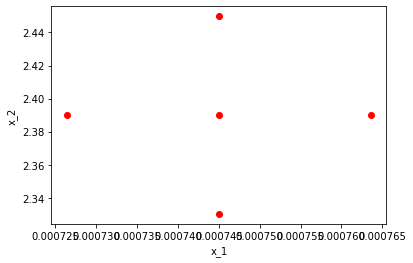

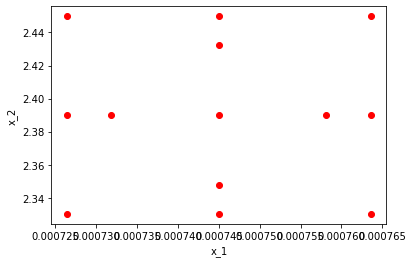

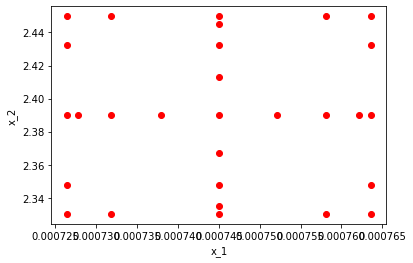

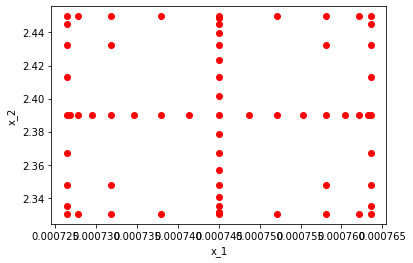

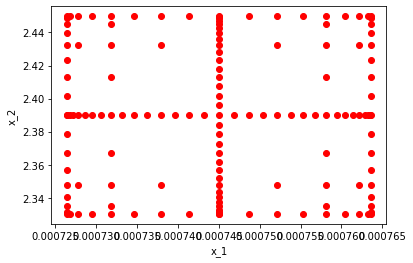

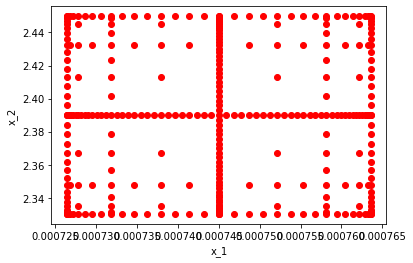

In [13]:
n_adaptations = 6
fig_means = plt.figure()
for i in range(n_adaptations):
    sampler.next_level_sparse_grid()
    plot_sampling_plan()
    # this command executes the actions
    campaign.execute().collate(progress_bar=True)

## Dimension-adaptive sparse grids

The sparse grids shown above are **isotropic**, in the sense that both inputs are treated the same. While isotropic sparse grids contains less points compared to the standard SC method, they will not scale very well when we have 27 inputs. 

In this case we can opt to apply the dimension-adaptive version of the SC sampler, in order to create an **anisotropic** sparse grid. This process is iterative in nature, usually staring from a single point. Unlike the isotropic case, only a certain (combination of) parameters will get refined. 

At each iteration, the code is evaluated at certain (so-called *admissible*) refinements, the `x` symbols in the cartoon below. Refinement means adding another tensor product where the quadrature order of one or more inputs is increased by one. Only one of the admissible refinements will get accepted, creating an anisotropic sampling plan.

![](images/adapt.png)

To determine which of the admissible refinement gets accepted, an error measure is computed for every refinement. The one with the highest error is accepted. Here we will use *hierarchical surplus*, defined above. For more information see [2,3].

We will create a new campaign, the `params` dict and the `actions` do no need to redefined.

In [14]:
campaign = uq.Campaign(name='HIV_SC_adaptive', params=params, actions=actions)

We do redefine `vary`, as we will include all 27 inputs in the uncertainty analysis this time.

In [15]:
vary = {}
#Lower and upper parameter limits
xl = .975*nominal; xu = 1.025*nominal
for i in range(27):
    vary[param_names[i]] = cp.Uniform(xl[i], xu[i])

Some changes must be made in the sampler as well, as now we set `dimension_adaptive = True`.

In [16]:
sampler = uq.sampling.SCSampler(vary=vary, polynomial_order=1, quadrature_rule='C', sparse=True,
                                growth=True, dimension_adaptive=True)
campaign.set_sampler(sampler)

Run the first ensemble, which consists of just a single sample:

In [17]:
campaign.execute().collate(progress_bar=True)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.61it/s]


To analyse the results (and execute the dimension adaptivity), we need an `SCAnalysis` object:

In [18]:
analysis = uq.analysis.SCAnalysis(sampler=sampler, qoi_cols=[QOI])
# perform analysis (basically estimates moments, Sobol analysis, and updates internal state of analysis)
campaign.apply_analysis(analysis)

/home/wouter/.local/lib/python3.7/site-packages/easyvvuq-1.1.1-py3.7.egg/easyvvuq/analysis/sc_analysis.py:1097: RuntimeWarning: invalid value encountered in true_divide
  S_u[u] = D_u[u] / D


Now we'll refine the grid several times in an anisotropic fashion. Here

* `look_ahead`: determines the new admissible candidate refinements.
* `campaign.get_collation_result()`: get the data frame with all code samples.
* `adapt_dimension`: compute the hierarchical surplus at all candidate refinements, and accept the one with the highest surplus.

In [19]:
number_of_adaptations = 15
for i in range(number_of_adaptations):
    # compute candidate refinements
    sampler.look_ahead(analysis.l_norm)
    # run ensemble (at new locations only)
    campaign.execute().collate(progress_bar=True)
    # get data frame
    data_frame = campaign.get_collation_result()
    # adapt the sampling plan
    analysis.adapt_dimension(QOI, data_frame)
    # we must apply the analysis to update its internal state
    campaign.apply_analysis(analysis)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.65it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.42it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  7.82it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.20it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████

This command retrieves the result after all refinements:

In [20]:
results = campaign.get_last_analysis()

The `adaptation_table` shows a plot of that visualizes which inputs got refined. Again, each refinement is another tensor product of 1D quadrature points, where the quadrature order of at least 1 input is increased. Note that the algorithm will focus on a subset of inputs.

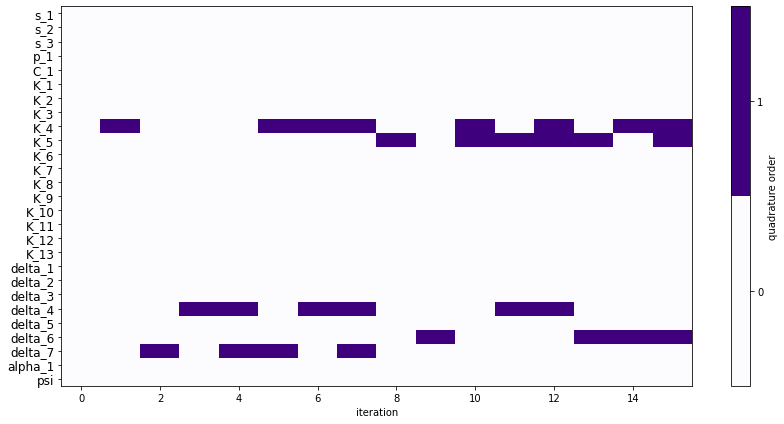

In [21]:
analysis.adaptation_table()

Here we will compute confidence intervals:

In [22]:
def get_confidence_intervals(samples, conf=0.9):
    """
    Compute the confidence intervals given an array of samples

    Parameters
    ----------
    samples : array
        Samples on which to compute the intervals.
    conf : float, optional, must be in [0, 1].
        The confidence interval percentage. The default is 0.9.

    Returns
    -------
    lower : array
        The lower confidence bound..
    upper : array
        The upper confidence bound.

    """

    # ake sure conf is in [0, 1]
    if conf < 0.0 or conf > 1.0:
        print('conf must be specified within [0, 1]')
        return

    # lower bound = alpha, upper bound = 1 - alpha
    alpha = 0.5 * (1.0 - conf)

    # arrays for lower and upper bound of the interval
    n_samples = samples.shape[0]
    N_qoi = samples.shape[1]
    lower = np.zeros(N_qoi)
    upper = np.zeros(N_qoi)

    # the probabilities of the ecdf
    prob = np.linspace(0, 1, n_samples)
    # the closest locations in prob that correspond to the interval bounds
    idx0 = np.where(prob <= alpha)[0][-1]
    idx1 = np.where(prob <= 1.0 - alpha)[0][-1]

    # for every location of qoi compute the ecdf-based confidence interval
    for i in range(N_qoi):
        # the sorted surrogate samples at the current location
        samples_sorted = np.sort(samples[:, i])
        # the corresponding confidence interval
        lower[i] = samples_sorted[idx0]
        upper[i] = samples_sorted[idx1]

    return lower, upper

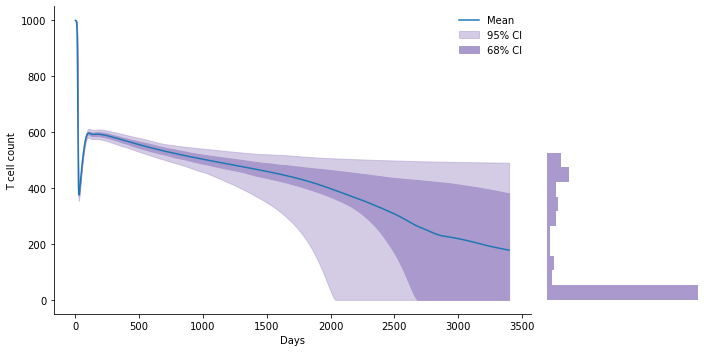

In [23]:
from matplotlib import gridspec

x = range(analysis.N_qoi)

code_samples = analysis.get_sample_array(QOI)
n_samples = code_samples.shape[0]

#confidence bounds
lower1, upper1 = get_confidence_intervals(code_samples, conf=0.63)
lower2, upper2 = get_confidence_intervals(code_samples, conf=0.95)

fig = plt.figure(figsize=(10,5))
spec = gridspec.GridSpec(ncols=2, nrows=1,
                          width_ratios=[3, 1])

ax1 = fig.add_subplot(spec[0])
ax2 = fig.add_subplot(spec[1], sharey=ax1)
ax2.get_xaxis().set_ticks([])
fig.subplots_adjust(wspace=0)
plt.setp(ax2.get_yticklabels(), visible=False)

ax1.fill_between(x, lower2, upper2, color='#aa99cc', label='95% CI', alpha=0.5)
ax1.fill_between(x, lower1, upper1, color='#aa99cc', label='68% CI')

mean = results.describe(QOI, 'mean')
ax1.plot(x, mean, label='Mean')

ax1.legend(loc=0, frameon=False)

ax1.set_xlabel('Days')
ax1.set_ylabel('T cell count')
ax2.axis('off')
sns.despine(top=True)
ax2.hist(code_samples[:, -1], orientation='horizontal', color='#aa99cc')

plt.tight_layout()

Finally, we will create a plot with all first-order Sobol indices `S_i`, which shows the fraction of the output variance (vs time here), that each input variable is responsible for *by itself*. To also estimate higher-order effects (the fraction of variance obtained by simultaneously varying 2 or more inputs together), we sum all first-order indices. Where this sum is close to one, there is (almost) no higher-order effect.

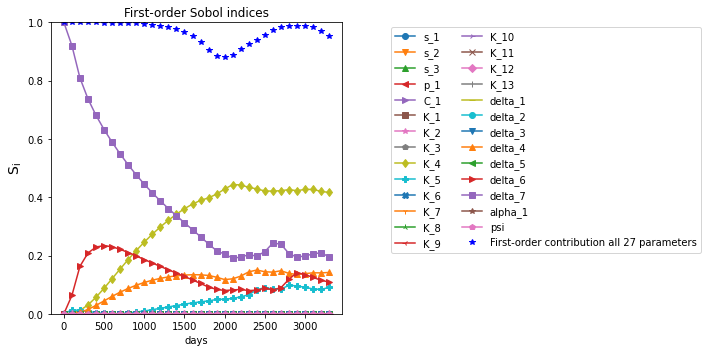

In [24]:
from itertools import cycle

# color = cycle(['b', 'r', 'g', 'm', 'c', 'k'])
marker = cycle(['o', 'v', '^', '<', '>', 's', '*', 'p', 'd', 'P', 'X', 
                '1', '2', '3', '4', 'x', 'D', '|', '_'])
skip = 100
x = range(0, analysis.N_qoi, skip)

fig = plt.figure(figsize=[10, 5])
ax = fig.add_subplot(121, title=r'First-order Sobol indices',
                      xlabel="days", ylim=[0,1])
ax.set_ylabel(r'$S_i$', fontsize=14)
sobols_first = results.sobols_first(QOI)

first_order_contribution = 0

for param in sobols_first.keys():
    ax.plot(x, sobols_first[param][0:-1:skip], label=param, marker=next(marker))
    first_order_contribution += sobols_first[param][0:-1:skip]
    
ax.plot(x, first_order_contribution, 'b*', label=r'First-order contribution all 27 parameters')

# place legend on empty axes on the right
handles, labels = ax.get_legend_handles_labels()    # ax1 legend
ax2 = fig.add_subplot(122)                          # ax2
ax2.axis('off')                                     # make ax2 empty
ax2.legend(handles, labels, ncol=2)                 # place ax1 legend on ax1
plt.tight_layout()

## References

[1] T. Loudon and S. Pankavich. _Mathematical Analysis and Dynamic Active Subspaces for a Long term model of HIV_. arXiv:1604.04588, 2016

[2] Edeling, W., Arabnejad, H., Sinclair, R., Suleimenova, D., Gopalakrishnan, K., Bosak, B., ... & Coveney, P. V. (2021). The impact of uncertainty on predictions of the CovidSim epidemiological code. Nature Computational Science, 1(2), 128-135.

[3] Ma, X., & Zabaras, N. (2009). An adaptive hierarchical sparse grid collocation algorithm for the solution of stochastic differential equations. Journal of Computational Physics, 228(8), 3084-3113.